# Assignment 4 - SMAI - CNN and AutoEncoders

In [1]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files/task-4.3")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files/task-4.3


In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import copy
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import wandb
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

In [4]:
from src_torch import *
from src_torch.utils import train, evaluate
from src_torch.classifiers import *

## (4.1) - Data Visualization and Preprocessing

### (4.1.0) - Data Loading

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# loading the MNIST data
mnist_train = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=True,
    transform=transform, download=True
)

mnist_test = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=False,
    transform=transform, download=True
)

print(f"Length of Train data: {len(mnist_train)}")
print(f"Length of Test data: {len(mnist_test)}")

Length of Train data: 60000
Length of Test data: 10000


### (4.1.1) - Showing distribution of classes

In [ ]:
labels = []
for data, label in mnist_dataset:
    labels.append(label)

labels = np.array(labels)

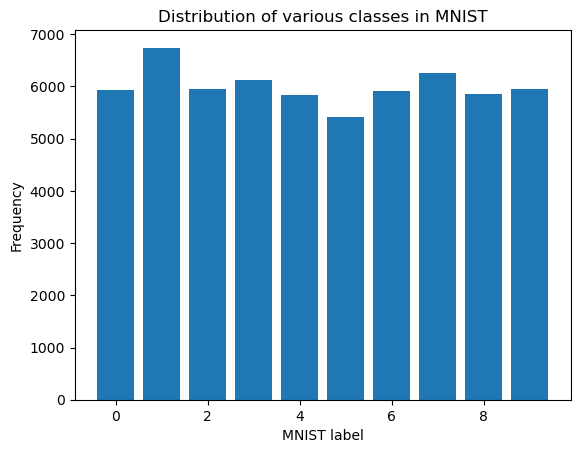

In [ ]:
fig, ax = plt.subplots(1, 1)

unique_labels, label_freq = np.unique(labels, return_counts=True)

ax.bar(unique_labels, label_freq)
ax.set_title("Distribution of various classes in MNIST")
ax.set_xlabel("MNIST label")
ax.set_ylabel("Frequency")

plt.show()

### (4.1.2) Visualizing samples from MNIST dataset

In [ ]:
features = mnist_dataset.data.view(-1, 28, 28)
labels = mnist_dataset.targets
print(features.shape)
print(labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


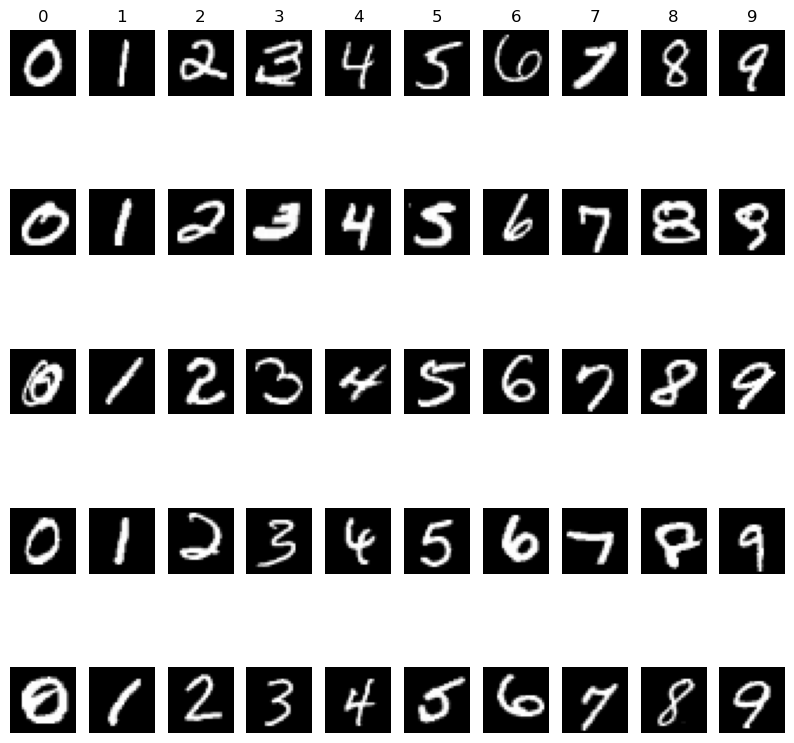

In [ ]:
examples_per_class = 5
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(10, 10))
for cls_idx, cls_name in enumerate(classes):
    idxs = np.where(labels == cls_idx)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls_idx + 1)
        plt.imshow(features[idx], cmap='gray')
        plt.axis("off")
        if i == 0:
            plt.title(f"{cls_name}")

plt.show()

### (4.1.4) Splitting data into train/val splits

In [6]:
val_ratio = 0.3
val_size = int(val_ratio * len(mnist_train))
train_size = len(mnist_train) - val_size

train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

print(f"Length of Training Data: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(mnist_test)}")

Length of Training Data: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


## (4.2) Model Building

### (4.2.3) Baseline CNN model

In [7]:
untrained_model = SimpleCNN()
print(untrained_model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


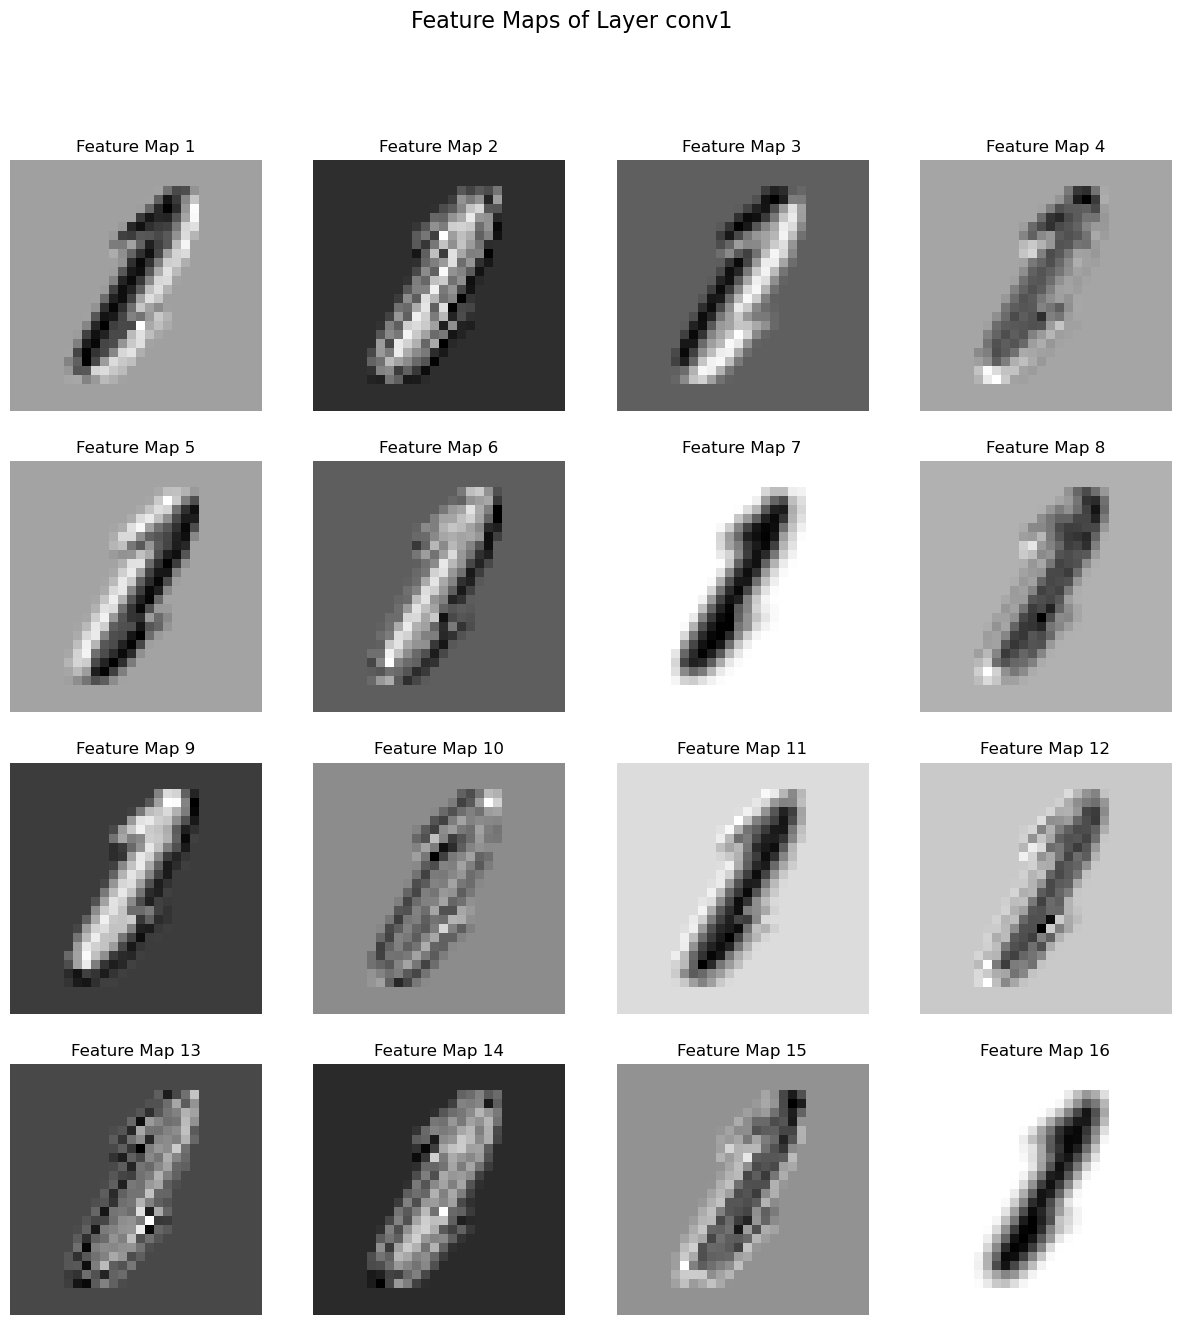

In [8]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(untrained_model, image, 'conv1')

In [20]:
# Setup model, criterion and optimizer
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, criterion, optimizer, train_dataset, val_dataset, print_every=10000)

Epoch: 1 | Train Accuracy: 96.162 | Val Accuracy: 96.228|  Train loss: 0.1282 | Val loss: 0.1290

Epoch: 2 | Train Accuracy: 97.907 | Val Accuracy: 97.644|  Train loss: 0.0754 | Val loss: 0.0810

Epoch: 3 | Train Accuracy: 98.290 | Val Accuracy: 97.850|  Train loss: 0.0585 | Val loss: 0.0685

Epoch: 4 | Train Accuracy: 98.476 | Val Accuracy: 98.156|  Train loss: 0.0498 | Val loss: 0.0606

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/richard/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1051640/1270205534.py", line 6, in <module>
    train(model, criterion, optimizer, train_dataset, val_dataset, print_every=10000)
  File "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/src_torch/utils.py", line 82, in train
    logits = model(X_minibatch)
  File "/home/richard/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/src_torch/classifiers/mnist_cnn.py", line 28, in forward
    x = self.maxpool1(x)
  File "/home/richard/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/richard/.loc

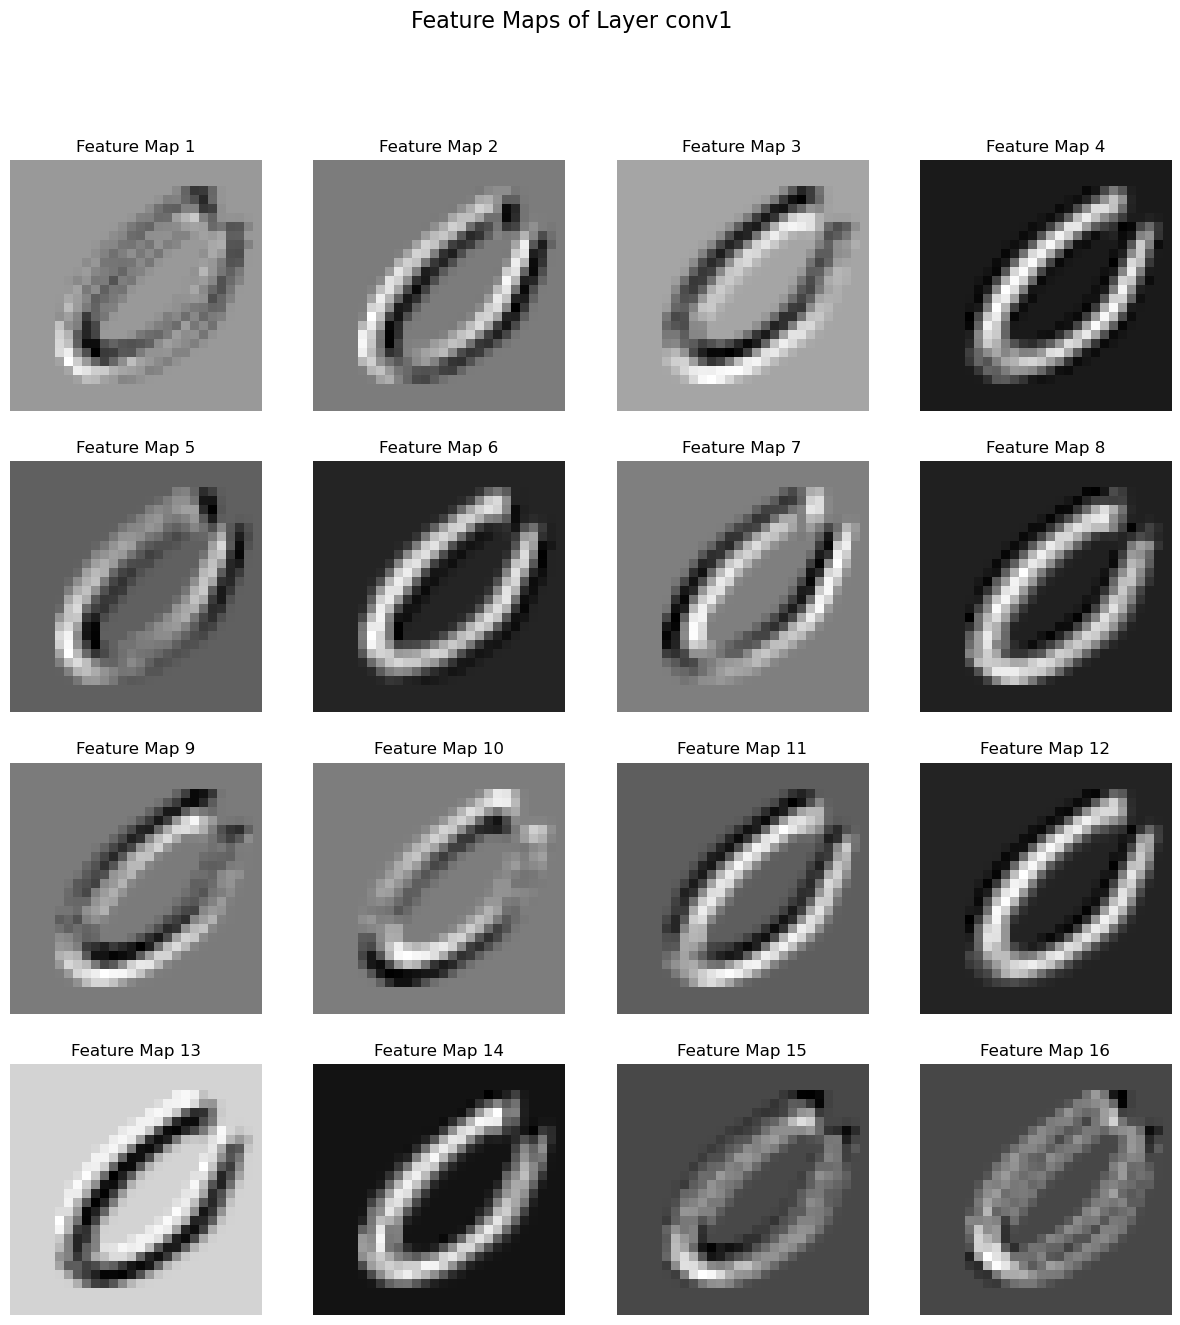

In [27]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(model, image, 'conv1')

## WANDB config

In [40]:
def get_model(config):
    num_classes = config.pop("num_classes", 10)
    num_channels = config.pop("num_channels", 16)
    dropout = config.pop("dropout", 0.1)
    num_conv_layers = config.pop("num_conv_layers", 2)
    kernel_size = config.pop("kernel_size", 3)
    stride = config.pop("stride", 1)
    
    model = SimpleCNN(
        num_classes, kernel_size, stride, num_channels, dropout
    )
    return model

def get_criterion(crit_name):
    if crit_name == "CE":
        return nn.CrossEntropyLoss()
    else:
        return nn.CrossEntropyLoss()

def get_optimizer(config, model):
    lr = config["learning_rate"]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def trigger_training(config, train_dataset, val_dataset):
    np.random.seed(42)
    # getting the model, criterion and optimizer
    model = get_model(config["model"])
    print(model)
    criterion = get_criterion(config["criterion"])
    optimizer = get_optimizer(config["optimizer"], model)

    # training config
    train_config = config["training"]
    
    train(
        model, criterion, optimizer, train_dataset, val_dataset, **train_config)
    
    return model

In [41]:
def make_wandb_run_name(config):
    model_config = config["model"]
    optim_config = config["optimizer"]
    train_config = config["training"]

    channels = model_config["num_channels"]
    kernel = model_config["kernel_size"]
    stride = model_config["stride"]
    dropout = model_config["dropout"]

    lr = optim_config["learning_rate"]
    batch = train_config["batch_size"]

    run_name = f"C{channels}-k{kernel}-s{stride}-dropout{dropout}-lr{lr}-batch{batch}"
    return run_name

In [42]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))
    # setting the wandb run name for the current config
    run_name = make_wandb_run_name(config)
    print(f"Run Name: {run_name}")
    run.name = run_name
    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [45]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "num_conv_layers": 2,
            "num_channels": 16,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 1e-2,
        },
        "training": {
            "batch_size": 100,
            "epochs": 10,
            "print_every": 100,
            "log_wandb": True,
            "verbose": True
        }
    }
}

In [ ]:
wandb.init(
    project="smai-assignment3-task4",
    config=config
)

wandb.run.name = "testing"
trigger_training(config["parameters"], train_dataset, val_dataset)
wandb.finish()

In [46]:
trigger_training(config["parameters"], train_dataset, val_dataset)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Number of Iterations Per Epoch: 420
Iteration: 100/4200 | loss = 0.0651
Iteration: 200/4200 | loss = 0.1406
Iteration: 300/4200 | loss = 0.0386
Iteration: 400/4200 | loss = 0.0789


KeyboardInterrupt: 

In [12]:
model = get_model(config["parameters"]["model"])
optimizer = get_optimizer(config["parameters"]["optimizer"], model)
criterion = get_criterion(config["parameters"])

print(model)
print(optimizer)
print(criterion)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


In [13]:
f = open(os.path.join(YAML_FOLDER, "two-conv-grid.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task4', 'name': 'two-conv-layers-grid-search', 'parameters': {'criterion': {'value': 'CE'}, 'model.conv_layers': {'value': 2}, 'model.num_channels': {'values': [8, 16, 32, 64, 128]}, 'model.kernel_size': {'values': [1, 3, 5]}, 'model.stride': {'values': [1, 3, 5]}, 'model.dropout': {'values': [0, 0.1, 0.25, 0.5]}, 'model.num_classes': {'value': 10}, 'optimizer.learning_rate': {'values': [0.0001, 0.0005, 0.001, 0.01]}, 'training.batch_size': {'values': [32, 64, 128]}, 'training.epochs': {'value': 50}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': False}}}


In [14]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task4")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: burzvqi8
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task4/sweeps/burzvqi8


In [15]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

wandb: Agent Starting Run: 0n84udyn with config:
wandb: 	criterion: CE
wandb: 	model.conv_layers: 2
wandb: 	model.dropout: 0
wandb: 	model.kernel_size: 1
wandb: 	model.num_channels: 8
wandb: 	model.num_classes: 10
wandb: 	model.stride: 1
wandb: 	optimizer.learning_rate: 0.0001
wandb: 	training.batch_size: 32
wandb: 	training.epochs: 50
wandb: 	training.log_wandb: True
wandb: 	training.verbose: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vanshg. Use `wandb login --relogin` to force relogin


Run Name: C8-k1-s1-dropout0-lr0.0001-batch32


Run 0n84udyn errored: TypeError("trigger_training() missing 2 required positional arguments: 'X_val' and 'y_val'")
wandb: ERROR Run 0n84udyn errored: TypeError("trigger_training() missing 2 required positional arguments: 'X_val' and 'y_val'")
wandb: Agent Starting Run: v7t8zdc9 with config:
wandb: 	criterion: CE
wandb: 	model.conv_layers: 2
wandb: 	model.dropout: 0
wandb: 	model.kernel_size: 1
wandb: 	model.num_channels: 8
wandb: 	model.num_classes: 10
wandb: 	model.stride: 1
wandb: 	optimizer.learning_rate: 0.0001
wandb: 	training.batch_size: 64
wandb: 	training.epochs: 50
wandb: 	training.log_wandb: True
wandb: 	training.verbose: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Ctrl + C detected. Stopping sweep.
